## 0.1 create gene list

Either Tumor or Fibroblast is not available in given obs_name. None is returned.
Either Tumor or Endothelial is not available in given obs_name. None is returned.
Either Tumor or Pericyte is not available in given obs_name. None is returned.


/tmp/ipykernel_38318/3775587307.py:57: PerformanceWarning: indexing past lexsort depth may impact performance.
  tumor_genes_intersection = contents.loc[(True, True, True, True, True, True)].values.ravel().tolist()


Either Fibroblast or Tumor is not available in given obs_name. None is returned.
Either Endothelial or Tumor is not available in given obs_name. None is returned.
Either Pericyte or Tumor is not available in given obs_name. None is returned.


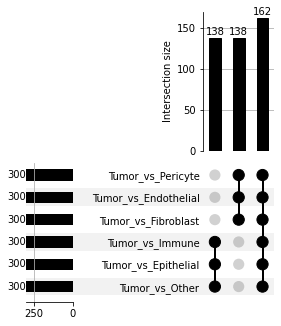

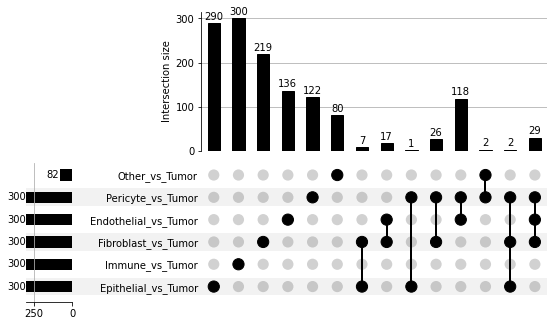

In [1]:
import upsetplot
import anndata
import pandas as pd
from pathlib import Path
from ikarus import gene_list, utils

# tumor gene list
paths = [
    Path("../data/laughney20_lung/"),
    Path("../data/lee20_crc/")
]
names = [
    "laughney",
    "lee"
]
obs_names = [
    "major_hallmark_corrected",
    "major_hallmark_corrected"
]
label_upregs = [
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor"
]
label_downregs = [
    "Other",
    "Epithelial",
    "Immune",
    "Fibroblast",
    "Endothelial",
    "Pericyte"
]
adatas = {}
for path, name in zip(paths, names):
    adatas[name] = anndata.read_h5ad(path / "adata.h5ad")
    
signatures = gene_list.create_all(
    label_upregs_list=label_upregs,
    label_downregs_list=label_downregs,
    adatas_dict=adatas,
    names_list=names,
    obs_names_list=obs_names,
    integration_fun=utils.intersection_fun,
    top_x=300
)

tumor_genes_union = []
for i in signatures.values():
    tumor_genes_union += i
tumor_genes_union = list(set(tumor_genes_union)) # unique genes

contents = upsetplot.from_contents(signatures)
_ = upsetplot.plot(contents, show_counts='%d')
tumor_genes_intersection = contents.loc[(True, True, True, True, True, True)].values.ravel().tolist()


# normal gene list
label_downregs = [
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor"
]
label_upregs = [
    "Other",
    "Epithelial",
    "Immune",
    "Fibroblast",
    "Endothelial",
    "Pericyte"
]
adatas = {}
for path, name in zip(paths, names):
    adatas[name] = anndata.read_h5ad(path / "adata.h5ad")

signatures = gene_list.create_all(
    label_upregs_list=label_upregs,
    label_downregs_list=label_downregs,
    adatas_dict=adatas,
    names_list=names,
    obs_names_list=obs_names,
    integration_fun=utils.intersection_fun,
    top_x=300
)

contents = upsetplot.from_contents(signatures)
_ = upsetplot.plot(contents, show_counts='%d')

normal_genes_union = []
for i in signatures.values():
    normal_genes_union += i
normal_genes_union = list(set(normal_genes_union)) # unique genes

overlap = list(set(tumor_genes_union) & set(normal_genes_union))

normal_genes = list(set(normal_genes_union) - set(overlap))
tumor_genes = tumor_genes_intersection

gene_list.save_gmt([normal_genes, tumor_genes], ["Normal", "Tumor"], out_dir="../out")

## 0.2 train model

In [2]:
import anndata
import pandas as pd
from pathlib import Path
from ikarus import classifier, utils


paths = [
    Path("../data/laughney20_lung/"),
    Path("../data/lee20_crc/")
]
names = [
    "laughney",
    "lee"
]
adatas = {}
for path, name in zip(paths, names):
    adatas[name] = anndata.read_h5ad(path / "adata.h5ad")

signatures_path = Path("../out/signatures.gmt")

model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir="../out")

train_adata_list = [adatas["laughney"], adatas["lee"]]
train_names_list = ["laughney", "lee"]
obs_columns_list = ["tier_0_hallmark_corrected", "tier_0_hallmark_corrected"]

model.fit(train_adata_list, train_names_list, obs_columns_list, save=True)

## 0.3 make predictions

In [1]:
import anndata
import pandas as pd
from pathlib import Path
from ikarus import classifier, utils


paths = [
    Path("../data/lambrechts18_lung/"),
    Path("../data/kildisiute21_neuroblastoma_10x/"),
    Path("../data/kildisiute21_neuroblastoma_celseq2/"),
    Path("../data/tirosh17_headneck/")
]
names = [
    "lambrechts",
    "kildisiute_10x",
    "kildisiute_celseq2",
    "tirosh"
]
adatas = {}
cnvs = {}
for path, name in zip(paths, names):
    adatas[name] = anndata.read_h5ad(path / "adata.h5ad")
    cnv = pd.read_csv(path / "infercnv.observations.txt", sep=' ')
    cnv.columns = cnv.columns.astype('int')
    cnv.sort_index(axis=1, inplace=True)
    cnvs[name] = cnv.T
    
signatures_path = Path("../out/signatures.gmt")
model_path = Path("../out/core_model.joblib")
model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir=f"../out")
model.load_core_model(model_path)
for name in names:
    _ = model.predict(adatas[name], name, save=True)
    _ = model.cnv_correct(cnvs[name], adatas[name], save=True, name=name)
    _ = model.get_umap(adatas[name], name, save=True)

Trying to set attribute `.uns` of view, copying.


converged at iteration step: 39 with 0.0010 < 0.001


/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'core_pred' as categorical
/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'final_pred' as categorical
Trying to set attribute `.uns` of view, copying.


converged at iteration step: 18 with 0.0002 < 0.001


/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'core_pred' as categorical
/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'final_pred' as categorical
Trying to set attribute `.uns` of view, copying.


converged at iteration step: 44 with 0.0001 < 0.001


/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'core_pred' as categorical
/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'final_pred' as categorical
Trying to set attribute `.uns` of view, copying.


converged at iteration step: 9 with 0.0004 < 0.001


/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'core_pred' as categorical
/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'final_pred' as categorical
